<a href="https://colab.research.google.com/github/BachokunIAR/pytorch-deep-learning/blob/main/01_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu118'


# 1. Data (preparing and loading)

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="r", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="b", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

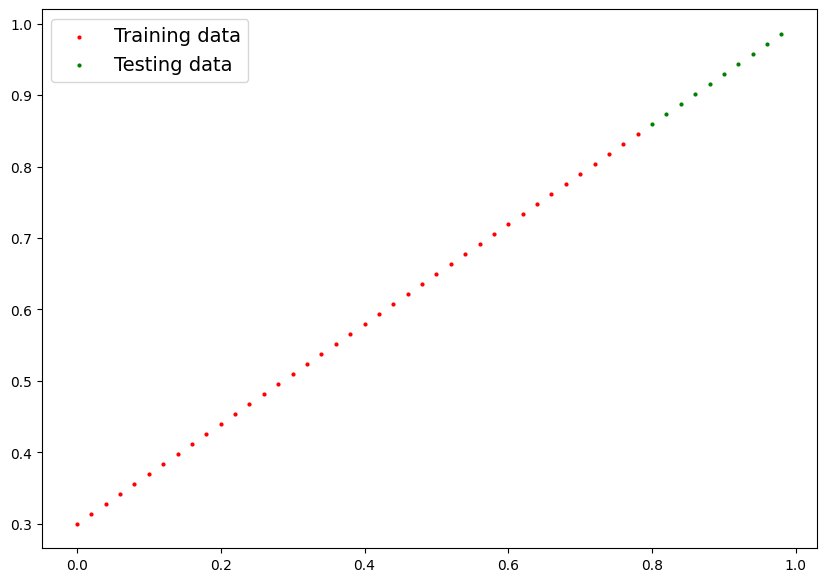

In [ ]:
plot_predictions();


# [2. Build model](https://)

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

We're going to jump right in.

We'll write the code first and then explain everything.

Let's replicate a standard linear regression model using pure PyTorch.

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

# PyTorch model building essentials

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using torch.inference_mode()

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


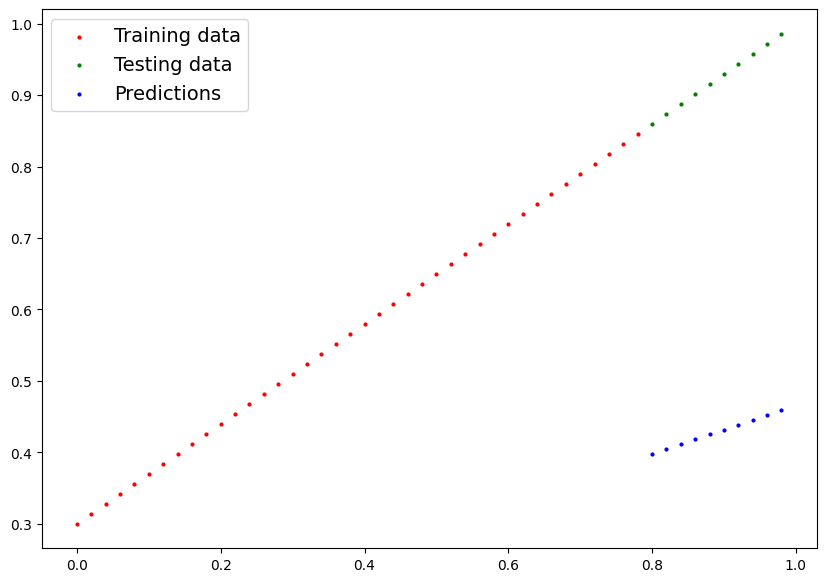

In [ ]:
plot_predictions(predictions = y_preds)

## `3. Train Model
# Creating a loss function and optimizer in PyTorch
For our problem, since we're predicting a number, let's use MAE (which is under torch.nn.L1Loss()) in PyTorch as our loss function.

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            # parameters of target model to optimize
                            lr=0.01)
# learning rate (how much the optimizer should
#change parameters at each step, higher=more (less stable), lower=less (might take a long time))

# PyTorch testing loop

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will
#pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions
    #to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()
    ### Testing
    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float))
      # predictions come in torch.float datatype, so comparisons
      #need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


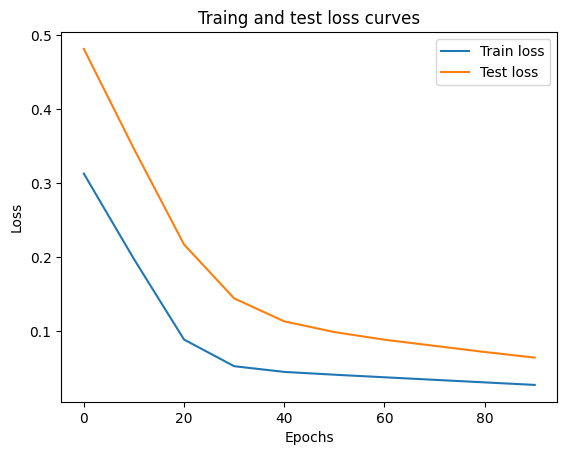

In [ ]:
plt.plot(epoch_count, train_loss_values,label = 'Train loss')
plt.plot(epoch_count,test_loss_values, label = 'Test loss')
plt.title('Traing and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# 4. Making predictions with a trained PyTorch model (inference)

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:
1. Set the model in evaluation mode (model.eval())
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

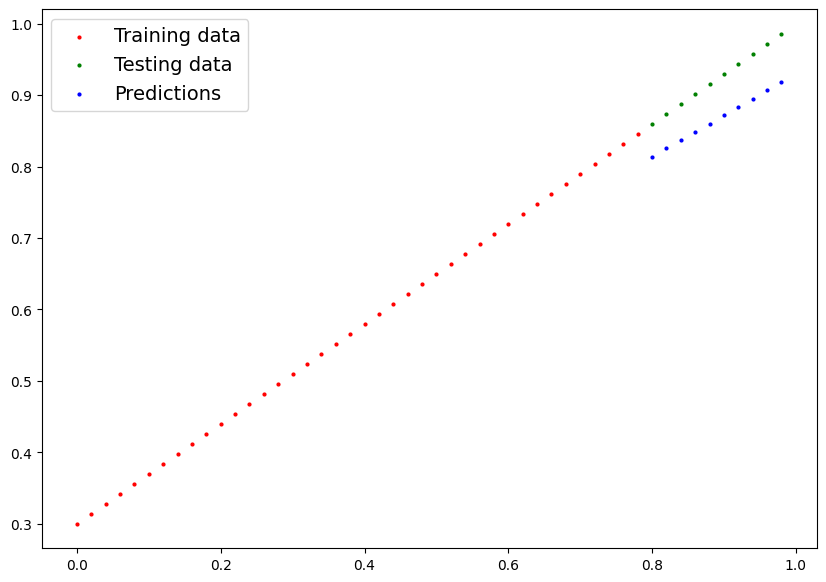

In [ ]:
plot_predictions(predictions = y_preds)

# 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the PyTorch saving and loading models guide):


1. Torch.save : Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.

2. torch.load : Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

3. torch.nn.Module.load_state_dict : Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

# Saving a PyTorch model's state_dict()

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().
see steps:

1. We'll create a directory for saving models to called models using Python's pathlib module.
2. We'll create a file path to save the model to.
3. We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

In [ ]:
from pathlib import Path
# 1. create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#2 create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# 3 save  the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           # only saving the state_dict() only saves the models learned parameters
           f = MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


In [ ]:
# Checking the save file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Oct 22 18:47 models/01_pytorch_workflow_model_0.pth


# Loading a saved PyTorch model's state_dict()

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
#Pytorch infererance
#1. put the loaded model into evaluation
loaded_model_0.eval()
# 2 use the inferenace mode context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model


In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all

T

```
`# This is formatted as code`
```

his time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU).

In [ ]:
import torch
from torch import nn # nn contains all of Pytorch's building blocks for neaural networks
import matplotlib.pyplot as plt



In [ ]:
# setting device agnistic code
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


# 6.1 DATA
we create our own data

Then we'll make a range of numbers between 0 and 1, these will be our X values.

In [ ]:
# create weight and bias
weight = 0.9
bias = 0.5

# create range values

start= 0
end = 1
step = 0.02
# create X and y (features and labels)
x = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*x + bias
x[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.5000],
         [0.5180],
         [0.5360],
         [0.5540],
         [0.5720],
         [0.5900],
         [0.6080],
         [0.6260],
         [0.6440],
         [0.6620]]))

In [ ]:
# split data
train_split = int(0.8*len(x))
X_train, y_train = x[:train_split],y[:train_split]
x_test, y_test = x[train_split:],y[train_split:]

len(X_train),len(y_train),len(x_test),len(y_test)

(40, 40, 10, 10)

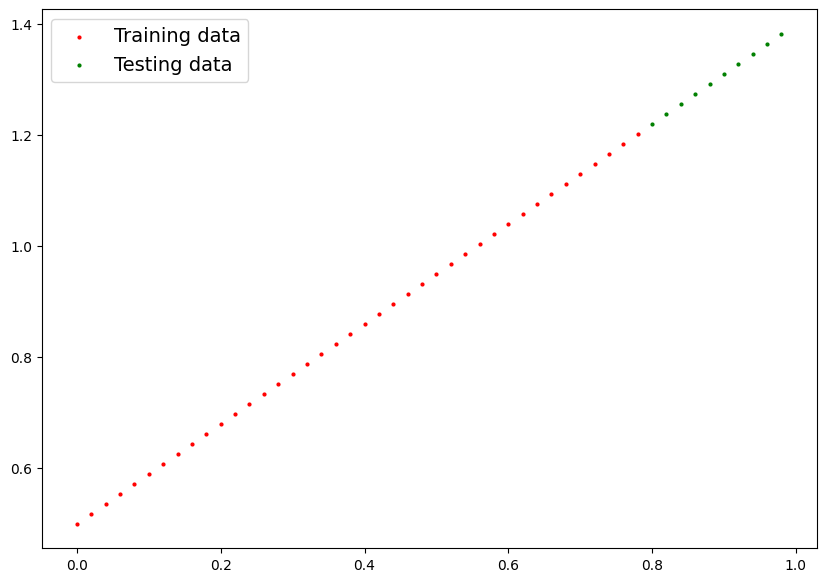

In [ ]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.

plot_predictions(X_train,y_train,x_test, y_test)


# 6.2 Building a PyTorch linear model

We've got some data, now it's time to make a model.

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using nn.Parameter(), we'll use nn.Linear(in_features, out_features) to do it for us.

Where in_features is the number of dimensions your input data has and out_features is the number of dimensions you'd like it to be output to.

In our case, both of these are 1 since our data has 1 input feature (X) per label (y).

In [ ]:
# Subclass nn.Module to make our model

class LinearRegressionModelV2(nn.Module):
  def __init__(self) -> None:
    super().__init__()
     # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                   out_features=1)
     # Define the forward computation (input data x flows through nn.Linear())

  def forward(self,x:torch.Tensor)-> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used
#for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(0)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.0075]])),
              ('linear_layer.bias', tensor([0.5364]))]))

Now let's put our model on the GPU (if it's available).

We can change the device our PyTorch objects are on using .to(device).

First let's check the model's current device.

In [ ]:
# check model device

next(model_1.parameters()).device

device(type='cpu')

# We then write the following code to send it to GPU if **availabe**

In [ ]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

# 6.3 Training
Building a training and test loop



In [ ]:
# craete the loss function
loss_fn = nn.L1Loss()
# create optimizer
optimizer = torch.optim.SGD(params= model_1.parameters(),# optimize newly created model's parameters
                            lr = 0.01)

In [ ]:
torch.manual_seed(0)

# set the number of epochs
epochs = 20000

# Put data on the available device
# Without this, error will happen (not all model/data on device)

x_train = X_train.to(device)
x_test = x_test.to(device)

y_train = y_train.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train() # train mode is on by default after construction

  # Forward pass
  y_pred = model_1(X_train)

  # 2 Calcukate loss
  loss = loss_fn(y_pred,y_train)

  # zero grad optimzer
  optimizer.zero_grad()
  # 4 Loss backward
  loss.backward()

  # 5. Step optimizer
  optimizer.step()

  ### Testing the model
  model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass

  with torch.inference_mode():
    test_pred = model_1(X_test)
    # Calculate the loss
    test_loss = loss_fn(test_pred , y_test)

  if epoch % 200 == 0:
    print(f'Epoch: {epoch} | Train loss {loss} | Test loss {test_loss}')


Epoch: 0 | Train loss 0.32022032141685486 | Test loss 0.7592753767967224
Epoch: 200 | Train loss 0.09439243376255035 | Test loss 0.2199857532978058
Epoch: 400 | Train loss 0.025705749168992043 | Test loss 0.059346459805965424
Epoch: 600 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 800 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 1000 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 1200 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 1400 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 1600 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 1800 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 2000 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 2200 | Train loss 0.004452228546142578 | Test loss 0.010926103219389915
Epoch: 2400 | Train loss 0.004452228546142578 | Test loss 0.01092

In [ ]:
# fifnd out the model learned  parameters

from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print('The model learned the following values for weights a nd bias:')
pprint(model_1.state_dict())
print('\nAnd the original values for weights and bias are ;')
print(f'Weights;{weight}, bias:{bias}')

The model learned the following values for weights a nd bias:
OrderedDict([('linear_layer.weight', tensor([[0.8962]])),
             ('linear_layer.bias', tensor([0.5059]))])

And the original values for weights and bias are ;
Weights;0.9, bias:0.5


# 6.4 Making predictions

In [ ]:
# Turn the model into evaluation mode
model_1.eval()
# make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(x_test)
y_preds


tensor([[1.2229],
        [1.2408],
        [1.2587],
        [1.2767],
        [1.2946],
        [1.3125],
        [1.3304],
        [1.3484],
        [1.3663],
        [1.3842]])

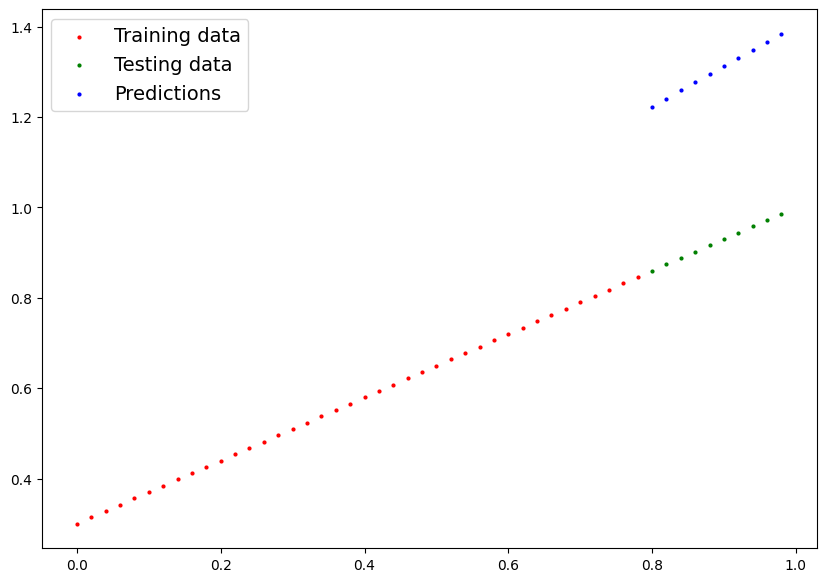

In [ ]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

# 6.5 Saving and loading a model

In [ ]:
from pathlib import Path
#1. Creat the model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True, exist_ok=True)
# 2. create model save path
MODEL_NAME ="01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

#3. save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')

torch.save(obj = model_1.state_dict(),# only saving the state_dict() only saves the models learned parameters
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


Loading back to see if it worked

In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# **EXERCISE**

In [ ]:
import matplotlib.pyplot as plt
from torch import nn
import torch

In [ ]:
# Setting up agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device:{device}')

Using device:cpu


In [ ]:
weight = 0.3
bias = 0.9

# creating range for the values

start =0
end = 10
step = 0.02
# # Create X and y (features and labels)
x = torch.arange(start,end,step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight*x + bias
x[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.9000],
         [0.9060],
         [0.9120],
         [0.9180],
         [0.9240],
         [0.9300],
         [0.9360],
         [0.9420],
         [0.9480],
         [0.9540]]))

In [ ]:
#import numpy as np
#train , valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])

# Split data
train_split = int(0.8 * len(x))
Xtrain, ytrain = x[:train_split], y[:train_split]
Xtest, ytest = x[train_split:], y[train_split:]

len(Xtrain), len(ytrain), len(Xtest), len(ytest)


(400, 400, 100, 100)

In [ ]:
def plot_predictions(train_data=Xtrain,
                     train_labels=ytrain,
                     test_data=Xtest,
                     test_labels=ytest,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="r", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="b", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

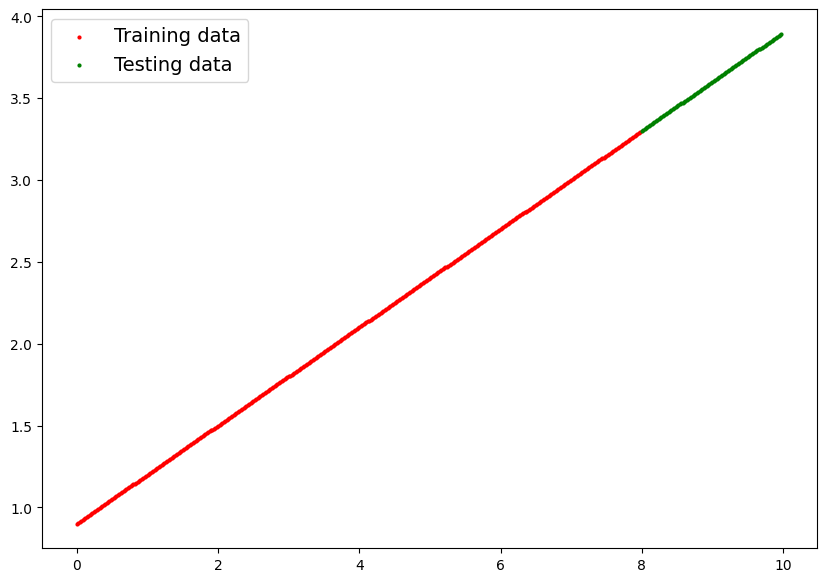

In [ ]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(Xtrain, ytrain, Xtest, ytest)

In [ ]:
# Building a Pytorch linear model

class LinearRegressionModelV2(nn.Module):
  def __init__(self)-> None:
    super().__init__()
    # using nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    # Define the forward computation (input data x flows through nn.Linear())
  def forward(self,x: torch.Tensor) -> torch.Tensor:
   return self.linear_layer(x)

torch.manual_seed(0)
model_r = LinearRegressionModelV2()
model_r,model_r.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.0075]])),
              ('linear_layer.bias', tensor([0.5364]))]))

In [ ]:
# Training the model

loss_fnn = nn.L1Loss()
optimizer= torch.optim.SGD(params = model_r.parameters(),
                           lr = 0.001)

In [ ]:
torch.manual_seed(0)

# set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)

Xtrain = Xtrain.to(device)
Xtest = Xtest.to(device)

ytrain = ytrain.to(device)
ytest = ytest.to(device)


for epoch in range(epochs):
  model_r.train() # train mode is on by default after construction

  # Forward pass
  y_pred = model_r(Xtrain)
  loss = loss_fnn(y_pred,ytrain)# 2 Calcukate loss

  optimizer.zero_grad()#3 zero grad optimzer
  loss.backward() # 4 Loss backward

  optimizer.step()# 5. Step optimizer

  model_r.eval() # put the model in evaluation mode for testing (inference)
    # r. Forward pass

  with torch.inference_mode():
    test_pred = model_r(Xtest)
    # Calculate the loss
    test_loss = loss_fnn(test_pred , ytest)

  if epoch % 500 == 0:
    print(f'Epoch: {epoch} | Train loss {loss} | Test loss {test_loss}')


Epoch: 0 | Train loss 1.5904289484024048 | Test loss 3.1278631687164307
Epoch: 500 | Train loss 1.5904289484024048 | Test loss 3.1278631687164307


In [ ]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_r.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[-0.0075]])),
             ('linear_layer.bias', tensor([0.5364]))])

And the original values for weights and bias are:
weights: 0.3, bias: 0.9


In [ ]:
# Making plot_predictions
# Turn model into evaluation mode
model_r.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_pred = model_r(Xtest)
y_preds

tensor([[1.2229],
        [1.2408],
        [1.2587],
        [1.2767],
        [1.2946],
        [1.3125],
        [1.3304],
        [1.3484],
        [1.3663],
        [1.3842]])

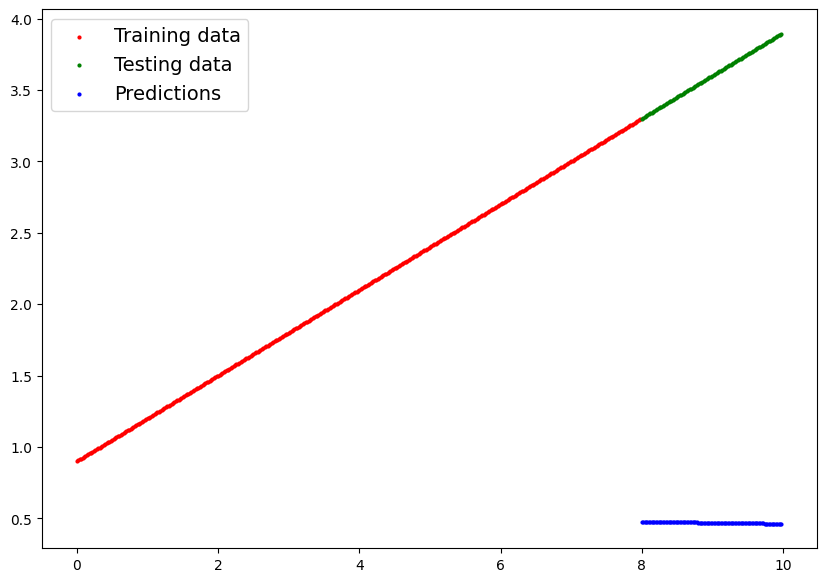

In [ ]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_pred.cpu())